# Generate music with an RNN


## Setup

In [2]:
#from google.colab import drive
#drive.mount('/content/drive/')

In [3]:
#pip install fluidsynth

In [4]:
#pip install pretty_midi

In [1]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf
import os

from IPython import display
from matplotlib import pyplot as plt
from typing import Dict, List, Optional, Sequence, Tuple
#from google.colab import files

In [2]:
#data_folder = 'midi_chopin_format_0_dataset' #to input as a string
#data_path = os.path.join('..','..','raw_data', data_folder)
#data_path = pathlib.Path(data_path)
data_path = pathlib.Path('../raw_data/midi_chopin_format_0_dataset/')
filenames = glob.glob(str(data_path/"*.mid"))
print('Number of files:', len(filenames))

Number of files: 131


## Fetch dataset

## Functions

In [3]:
#def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  #waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  #waveform_short = waveform[:seconds*_SAMPLING_RATE]
  #return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [4]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [5]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

In [6]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))

  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

In [7]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str, 
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [8]:
# TODO : Add padding on each piano records 
# TODO : Discuss/Ask about scaling for duration, steps 

def create_sequences(
    dataset: tf.data.Dataset, 
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels = targets = predicted notes
  # shift : spacing between two windows
  # stride : inside a given window, spacing between two notes ==> we don't want to skip notes so we take stride = 1*
  # drop_remainder : representing whether the last windows should be dropped if their size is smaller than size
    
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)

  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [9]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [10]:
def predict_next_note(
    notes: np.ndarray, 
    keras_model: tf.keras.Model, 
    temperature: float = 1.0) -> int:
  """Generates a note IDs using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']

  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

## Parameters

In [145]:
# General parameters 
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
_SAMPLING_RATE = 16000 # Sampling rate for audio playback
vocab_size = 128 # Represents the number of note pitches 
key_order = ['pitch', 'step', 'duration'] # Features we keep

# Hyper-parameters 
seq_length = 25
batch_size = 64
pitch_weight= 0.05
step_weight = 1.0
duration_weight = 1.0
patience = 10
epochs = 100
learning_rate = 0.001

# Parameters used to generate the music notes
temperature = 2
file_number = 100 #Choose one file among the existing file to start the prediction 
sample_file = filenames[file_number]
raw_notes = midi_to_notes(sample_file)
#example_file = 'example.midi'
#example_pm = notes_to_midi(
#    raw_notes, out_file=example_file, instrument_name=instrument_name)
pm = pretty_midi.PrettyMIDI(sample_file)
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print(f'Sample file: {sample_file}')

Sample file: ../raw_data/midi_chopin_format_0_dataset/chpn-p4_format0.mid


## Create the training dataset

In [146]:
def create_train_ds_per_file(filename) :

    notes = midi_to_notes(filename)

    #Fetching features and transform to tensorflow dataset 
    train_notes = np.stack([notes[key] for key in key_order], axis=1) #Keeps columns of key_order and transform to numpy.ndarray format
    notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)

    seq_length_temp = seq_length+1
    #Creating windows 
    windows = notes_ds.window(seq_length_temp, shift=1, stride=1,
                                  drop_remainder=True)
    # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
    flatten = lambda x: x.batch(seq_length_temp, drop_remainder=True)
    sequences = windows.flat_map(flatten)

    # Normalize note pitch
    def scale_pitch(x):
        x = x/[vocab_size,1.0,1.0]
        return x

    # Split the labels
    def split_labels(sequences):
        inputs = sequences[:-1]
        labels_dense = sequences[-1]
        labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

        return scale_pitch(inputs), labels

    seq_ds = sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)
        
    return seq_ds 

In [147]:
#Concatenate all batches of sequences by instanciating on the first file
seq_ds_all = create_train_ds_per_file(filenames[0])

for filename in filenames[1:] :
    seq_ds = create_train_ds_per_file(filename)
    seq_ds_all = seq_ds_all.concatenate(seq_ds)



/Users/aurelie_emma/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/pretty_midi/pretty_midi.py:97: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


In [148]:
#Shuffling batches and optmizing the training dataset for CPU speed
nb_elem_all = 247489 #HARDCODED - To discuss 
buffer_size = nb_elem_all - seq_length  # TO REDEFINE
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))
train_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(64, 25, 3), dtype=tf.float64, name=None), {'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None), 'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None), 'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})>

## Baseline model

In [32]:
def build_model() :
    
    ###################
    ###**STRUCTURE**###
    ###################
    input_shape = (seq_length, 3)
    inputs = tf.keras.Input(input_shape)
    x = tf.keras.layers.LSTM(128)(inputs)

    outputs = {
      'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
      'step': tf.keras.layers.Dense(1, name='step')(x),
      'duration': tf.keras.layers.Dense(1, name='duration')(x),
    }

    model = tf.keras.Model(inputs, outputs)

    loss = {
          'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
              from_logits=True),
          'step': mse_with_positive_pressure,
          'duration': mse_with_positive_pressure,
    }
    
    ###################
    ###**COMPILING**###
    ###################
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(
    loss=loss,
    loss_weights={
        'pitch': pitch_weight,
        'step': step_weight,
        'duration': duration_weight,
    },
    optimizer=optimizer,
    )

    return model 

model = build_model()

In [33]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 25, 3)]      0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 128)          67584       ['input_1[0][0]']                
                                                                                                  
 duration (Dense)               (None, 1)            129         ['lstm[0][0]']                   
                                                                                                  
 pitch (Dense)                  (None, 128)          16512       ['lstm[0][0]']                   
                                                                                              

In [34]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=patience,
        verbose=1,
        restore_best_weights=True),
]

In [35]:
%%time
history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/100


2022-12-07 17:44:39.616006: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-07 17:44:39.619766: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-07 17:44:39.854039: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-07 17:44:43.048899: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


49/49 [==============================] - 6s 23ms/step - loss: 0.3626 - duration_loss: 0.0493 - pitch_loss: 4.7367 - step_loss: 0.0765
Epoch 2/100
49/49 [==============================] - 1s 18ms/step - loss: 0.2900 - duration_loss: 0.0393 - pitch_loss: 4.4718 - step_loss: 0.0272
Epoch 3/100
49/49 [==============================] - 1s 18ms/step - loss: 0.2463 - duration_loss: 0.0380 - pitch_loss: 3.6022 - step_loss: 0.0283
Epoch 4/100
49/49 [==============================] - 1s 18ms/step - loss: 0.2317 - duration_loss: 0.0345 - pitch_loss: 3.3795 - step_loss: 0.0282
Epoch 5/100
49/49 [==============================] - 1s 18ms/step - loss: 0.2291 - duration_loss: 0.0343 - pitch_loss: 3.3678 - step_loss: 0.0264
Epoch 6/100
49/49 [==============================] - 1s 18ms/step - loss: 0.2278 - duration_loss: 0.0316 - pitch_loss: 3.3639 - step_loss: 0.0281
Epoch 7/100
49/49 [==============================] - 1s 18ms/step - loss: 0.2243 - duration_loss: 0.0314 - pitch_loss: 3.3482 - step_los

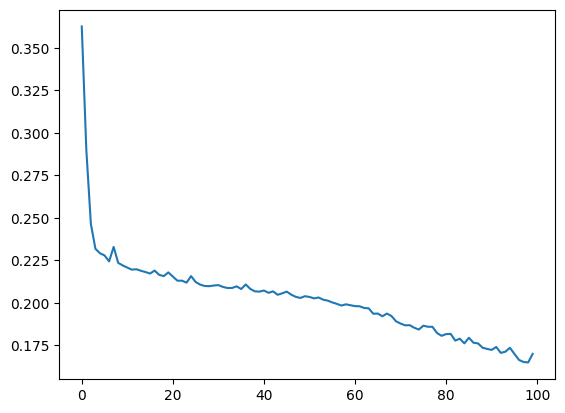

In [36]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

## Test model

In [149]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from keras_self_attention import SeqSelfAttention
from keras.datasets import imdb

In [150]:
def build_model() :
    
    ###################
    ###**STRUCTURE**###
    ###################
    
    input_shape = (seq_length, 3)
    inputs = tf.keras.Input(input_shape)
    x1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, return_sequences=True))(inputs)
    x2 = SeqSelfAttention(attention_activation='sigmoid')(x1)
    x3 = tf.keras.layers.Dropout(0.3)(x2)
    x4 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, return_sequences=True))(x3)
    x5 = SeqSelfAttention(attention_activation='sigmoid')(x4)
    x6 = tf.keras.layers.Dropout(0.3)(x5)
    x7 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512))(x6)
    
    outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x7),
  'step': tf.keras.layers.Dense(1, name='step')(x7),
  'duration': tf.keras.layers.Dense(1, name='duration')(x7),
}
    model = tf.keras.Model(inputs, outputs)

    loss = {
          'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
          'step': mse_with_positive_pressure,
          'duration': mse_with_positive_pressure,
    }
    
    ###################
    ###**COMPILING**###
    ###################
    #optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    optimizer = tf.keras.optimizers.RMSprop()

    model.compile(
    loss=loss,
    loss_weights={
        'pitch': pitch_weight,
        'step': step_weight,
        'duration': duration_weight,
    },
    optimizer=optimizer,
    )

    return model 

model = build_model()

/Users/aurelie_emma/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [151]:
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 25, 3)]      0           []                               
                                                                                                  
 bidirectional_27 (Bidirectiona  (None, 25, 1024)    2113536     ['input_10[0][0]']               
 l)                                                                                               
                                                                                                  
 seq_self_attention_18 (SeqSelf  (None, 25, 1024)    65601       ['bidirectional_27[0][0]']       
 Attention)                                                                                       
                                                                                            

In [152]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=patience,
        verbose=1,
        restore_best_weights=True),
]

In [153]:
%%time
history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/100


2022-12-08 00:44:01.097347: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-08 00:44:02.189960: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-08 00:44:02.190215: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-08 00:44:02.432228: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-08 00:44:02.472885: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-08 00:44:02.692805: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-08 00:44:02.714077: I tensorflow/core/grappler/optimizers/cust

24/24 [==============================] - 13s 206ms/step - loss: 2.1924 - duration_loss: 0.0508 - pitch_loss: 4.5261 - step_loss: 1.9153
Epoch 2/100
24/24 [==============================] - 4s 148ms/step - loss: 0.7786 - duration_loss: 0.3513 - pitch_loss: 4.1020 - step_loss: 0.2222
Epoch 3/100
24/24 [==============================] - 3s 143ms/step - loss: 0.2769 - duration_loss: 0.0406 - pitch_loss: 4.1415 - step_loss: 0.0292
Epoch 4/100
24/24 [==============================] - 3s 143ms/step - loss: 0.4251 - duration_loss: 0.0448 - pitch_loss: 4.0671 - step_loss: 0.1769
Epoch 5/100
24/24 [==============================] - 3s 143ms/step - loss: 0.3436 - duration_loss: 0.0714 - pitch_loss: 4.2763 - step_loss: 0.0585
Epoch 6/100
24/24 [==============================] - 3s 139ms/step - loss: 0.3863 - duration_loss: 0.0468 - pitch_loss: 3.9410 - step_loss: 0.1424
Epoch 7/100
24/24 [==============================] - 3s 141ms/step - loss: 0.2574 - duration_loss: 0.0418 - pitch_loss: 3.6530 - 

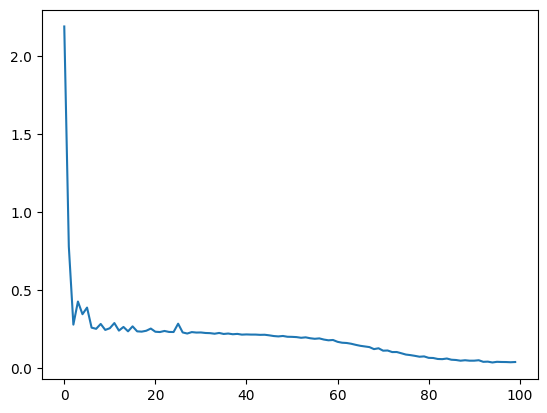

In [155]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()


## Generate notes

In [154]:
temperature = temperature
num_predictions = 250 #120

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

2022-12-08 00:49:43.775009: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-08 00:49:44.023611: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-08 00:49:44.043475: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-08 00:49:44.241760: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-08 00:49:44.256662: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-08 00:49:44.426600: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-08 00:49:44.440651: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 57ms/step


In [156]:
generated_notes.head(5)

,pitch,step,duration,start,end
0,61,0.208038,0.424027,0.208038,0.632065
1,74,0.065082,0.352430,0.273120,0.625550
2,75,0.116137,0.341176,0.389257,0.730433
3,62,0.128826,0.310279,0.518083,0.828362
4,68,0.139706,0.292352,0.657789,0.950141


In [157]:
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
#display_audio(out_pm)
#files.download(out_file)
model_outputs_directory_path = '../raw_data/model_outputs/'
custom = 'o14b'
filename = f"{custom}_{learning_rate}lrate_{batch_size}batch{epochs}epoch_{history.epoch[-1]}early_stop_{seq_length}seqlength_from_file_nb{file_number}.mid"
out_pm.write(os.path.join(model_outputs_directory_path, filename))

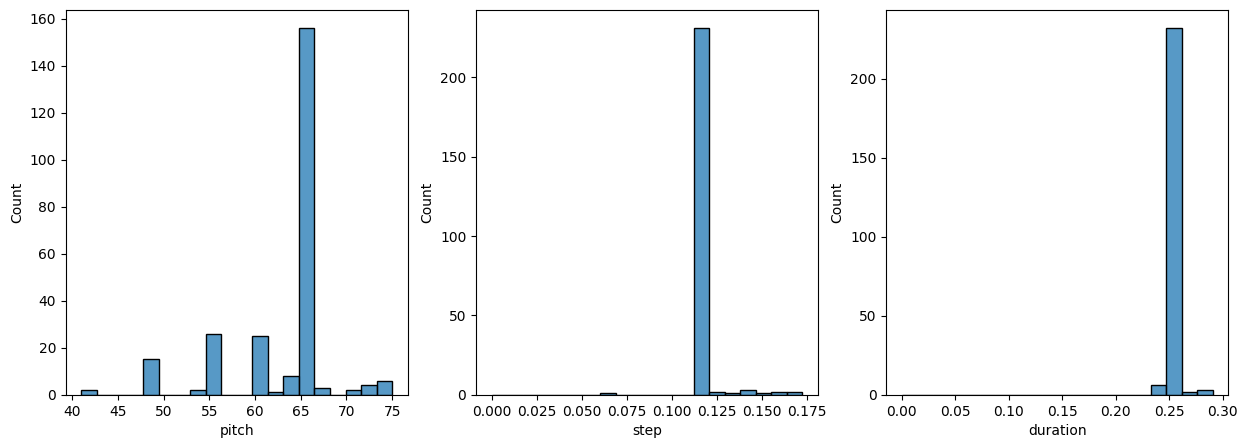

In [158]:
plot_distributions(generated_notes)